In [1]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import torch
import torch_geometric as tg
from tqdm import trange
import os
from scipy.spatial import KDTree
import networkx as nx

In [46]:
class PlaneGraphDataset(tg.data.Dataset):
    '''
    This class bundles the creation and saving as well as loading of a dataset of 3D graphs. If an instance is created, the class will 
    check in root directory if the dataset is already processed. If not, the process() method will be called. Furthermore, the
    dataset will be loaded. If the dataset shall be calculated again, the process() method must be called explicitely.
    '''
    def __init__(self, root, n_graphs_per_type=100, transform=None, pre_transform=None, size=(5,5)):
        '''
        Args:
        - root (str): The directory where the dataset should be stored, divided into processed and raw dirs
        '''
        self.root = root
        self.n_graphs_per_type = n_graphs_per_type
        self.size = size    
        super().__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        '''
        If this file exists in the raw directory, the download will be skipped. Download not implemented.
        '''
        return 'raw.txt'
    
    @property
    def processed_file_names(self):
        '''
        If this file exists in the processed directory, processing will be skipped. 
        Note: This does smh not work, therefore files are ATM recalculated every time.
        '''
        return ['data_00000.pt']
    
    def download(self):
        '''
        Download not implemented.
        '''
        pass
    
    def len(self):
        '''
        Returns the number of graphs in the dataset.
        '''
        return len([f for f in os.listdir(os.path.join(self.root, 'processed')) if f.startswith('data')])
    
    def get(self, idx):
        '''
        Returns the graph at index idx. 
        '''
        data = torch.load(os.path.join(self.processed_dir, 'data_{:05d}.pt'.format(idx)))
        return data
    
    def process(self):
        '''
        Here creation, processing and saving of the dataset happens. 
        '''
        planeGraph = PlaneGraphGenerator(size=self.size) # Create the planeGraph object
        for n in trange(self.n_graphs_per_type * 5):
            # Get graph features:
            pos, edge_index, label, node_attr, edge_attr = planeGraph.process_lattice(planeGraph.lattice_types[n % 5], n)
            
            # Create data object:
            data = tg.data.Data(x          = torch.tensor(node_attr, dtype=torch.float), 
                                edge_index = torch.tensor(edge_index, dtype=torch.int64), 
                                y          = torch.tensor(label, dtype=torch.float), 
                                pos        = torch.tensor(pos, dtype=torch.float),
                                edge_attr  = torch.tensor(edge_attr, dtype=torch.float))
            # Save data object:
            torch.save(data, os.path.join(self.processed_dir, 'data_{:05d}.pt'.format(n)))

class PlaneGraphGenerator():
    def __init__(self, size=(5,5)):
        '''
        Args:
        - size (tuple): The size of the lattice in x,y direction. The lattice will be size[0] x size[1] large.
        '''
        self.size = np.array(size) + 3
        self.lattice_types = {
            0: {'name': 'mP', 'nodes': self._get_P_nodes, 'binding_angle':   0, 'scale': [0, 0]},
            1: {'name': 'oP', 'nodes': self._get_P_nodes, 'binding_angle':  90, 'scale': [0, 0]},
            2: {'name': 'oC', 'nodes': self._get_C_nodes, 'binding_angle':  90, 'scale': [0, 0]},
            3: {'name': 'tP', 'nodes': self._get_P_nodes, 'binding_angle':  90, 'scale': [1, 1]},
            4: {'name': 'hP', 'nodes': self._get_P_nodes, 'binding_angle': 120, 'scale': [1, 1]}
        }
        
    def _get_P_nodes(self, angle=90):
        '''
        Get the nodes of a primitive lattice.
        '''
        scaling = np.sin(np.radians(angle))
        vec1 = np.arange(0,self.size[0])
        vec2 = np.arange(0,self.size[1])*scaling
        a, b = np.meshgrid(vec1,vec2)
        nodes = np.stack([a,b],axis=-1) # Stack them in a new axis
        nodes = np.reshape(nodes, (-1, 2)) # Reshape to an arr of nodes with shape (#nodes, 2)
        return nodes

    def _get_C_nodes(self):
        '''
        Get the nodes of a centred lattice.
        '''
        P = self._get_P_nodes()
        extra = P + np.array([0.5,0.5])
        return np.row_stack((P, extra))
    

    def process_lattice(self, arg_dict, n):
        '''
        Method that processes a lattice of a given type. The method is called with a dictionary holding parameters for one of the lattice types. It contains the following keys:
            - name: The name of the lattice type
            - nodes: The method to get the fitting fundamental lattice nodes
            - binding_angle: binding angle alpha of the lattice type. angle are in degrees. 0° means to generate a independent random angle (0,180)°
            - scale: A list of scaling factors [x,y] for the lattice type. 0 means to generate a random scaling factor (0,2)
        '''
        # Get lattice angles
        angle = arg_dict['binding_angle']
        if angle == 0:
            angle = rng.uniform(46,89,1)
            
        # Get the fundamental lattice nodes
        if arg_dict['name'] in ['hP']:
            # For hP lattice we need to give the angle to the nodes method so that sheared connections are equally long
            nodes = arg_dict['nodes'](angle)
        else:
            nodes = arg_dict['nodes']()
        inside_mask = self._get_inside_mask(nodes)
        nodes = self._shear_nodes(nodes, angle)
        # Find random scale and apply gaussian noise to the lattice accordingly
        scale = np.array(arg_dict['scale'])
        scale = np.where(scale == 0, rng.uniform(0.3,3,2), scale)
        noise_level = 0.05 / scale  # At this step we scale the noise down, so that the scaling later on does not affect the noise level
        nodes += rng.normal(0, noise_level, nodes.shape)
        
        # Find the connections between the nodes in a given radius
        cons= self._get_cons_in_radius(nodes, 1.3+np.mean(noise_level))
        # Apply the saved scaling
        nodes *= scale
        
        nodes, cons, inside_mask = self._add_defects(nodes, cons, inside_mask)
        node_attr = self.get_node_attr(nodes, cons)
        nodes, node_attr = nodes[inside_mask], node_attr[inside_mask]
        nodes /= scale
        cons = self._get_cons_in_radius(nodes, 1.3+np.mean(noise_level))
        nodes *= scale
        edge_attr = self.get_edge_attr(nodes, cons)
        labels = np.zeros((1,5))
        labels[0,n%5] = 1
        return nodes, cons, labels, node_attr, edge_attr

    
    def _get_cons_in_radius(self, nodes, radius):
        '''
        Get the connections in a radius as well as the total number of cons for each node.
        '''
        tree = KDTree(nodes)
        cons = tree.query_pairs(radius, output_type='ndarray', p=2)
        cons = cons.T
        cons = np.column_stack((cons, cons[::-1])) # Add the reverse connections
        return cons

    def _shear_nodes(self, nodes, binding_angle):
        '''
        Shear nodes by binding angle.
        '''
        delta = np.tan(np.radians(binding_angle))
        assert not np.any(delta == 0), 'Binding angle cannot be 0'
        nodes = nodes.astype(float)
        nodes = nodes + np.stack((nodes[:,1]/delta, np.zeros_like(nodes[:,1])), axis=1)
        return nodes

    def _add_defects(self, nodes, edge_index, inside_mask):
        '''
        Method that adds up to 10% of random defects (i.e. missing nodes) to the lattice. Should be called after _get_*_graph() but before
        _get_edge_attr() and _get_node_attr().
        '''
        # Draw up to 10% of unique random indices for nodes to be removed
        drop_indices = rng.choice(np.arange(len(nodes)), rng.integers(len(nodes)//10), replace=False)
        # Remove the nodes and labels
        nodes = np.delete(nodes, drop_indices, axis=0)
        inside_mask = np.delete(inside_mask, drop_indices, axis=0)
        # Delete every connection that refers to a removed node
        edge_index = np.delete(edge_index, np.where(np.isin(edge_index, drop_indices))[1], axis=1)
        
        # As edge_index refers to the original node indices, we need to adjust the indices of most connections
        # For this we create a mapping from old indices to new indices
        old_to_new = np.arange(len(nodes) + len(drop_indices))  # Start with an array of original indices; [0,1,2,3,4,5,...]
        old_to_new[drop_indices] = -1  # Mark the indices of the nodes to be deleted; eg. drop_indices = [1,3] -> [0,-1,2,-1,4,5,...]
        old_to_new = np.cumsum(old_to_new != -1) - 1  # Create a cumulative sum array; cumsum([True, False, True, False, True, True,...]) -1 -> [1,1,2,2,3,4,...] -1 -> [0,0,1,1,2,3,...]
        
        # # Update edge indices to reflect new node indices through broadcasting
        edge_index = old_to_new[edge_index]
        return nodes, edge_index, inside_mask
        
    def get_node_attr(self,nodes,cons):
        '''
        Method that returns the node attributes for each node in the graph. Should be called after creating the graph and adding defects.
        The node attributes have the shape (num_nodes, num_node_features). For each node, the node features are the following:
        - The bond orientational order parameters for l=4,6,8,10 (4 features)
        '''
        G = nx.Graph()
        G.add_edges_from(cons.T)
        boo_arr = np.zeros((len(nodes), 5), dtype=complex)
        n_neighbors = np.zeros(len(nodes))
        for i in range(len(nodes)):
            if i not in G.nodes:
                # node is not connected to any other node, return 0
                boo_arr[i] = np.zeros(5)
                n_neighbors[i] = 0
                continue
            # iterate over all nodes, get their neighbors
            neighbors = list(G.neighbors(i))
            n_neighbors[i] = len(neighbors)
            # calculate the bond orientational order parameters
            boo_ = np.zeros(5, dtype=complex)
            for n in neighbors:
                angle = np.arctan2(nodes[n,1] - nodes[i,1], nodes[n,0] - nodes[i,0])
                boo_ += np.array([np.exp(1j*2*angle), np.exp(1j*4*angle), np.exp(1j*6*angle), np.exp(1j*8*angle), np.exp(1j*10*angle)])   
            boo_arr[i] = np.abs(boo_ / len(neighbors)) 
        boo_arr = np.real(boo_arr)
        # return boo_arr
        return np.column_stack((boo_arr, n_neighbors))
        
    
    def get_edge_attr(self,nodes,cons):
        '''
        Method that returns the edge attributes for each edge in the graph. Should be called after creating the graph and adding defects.
        Returns an array of shape (len(edge_index[0])= #Edges, 1) with the length of each edge.
        '''
        # Get the edge vectors for each edge
        edge_vectors = nodes[cons[0]] - nodes[cons[1]]
        return np.linalg.norm(edge_vectors, axis=1).reshape(-1,1)   
    
    def _get_inside_mask(self, nodes):
        '''
        Method that returns the indices of the border nodes of the lattice. 
        '''
        mask = np.any(np.logical_or(nodes < np.array([1,1]), nodes >= self.size-3), axis=1)
        return ~mask
    

def plot_graph_tg(data: tg.data.Data):
    '''
    Function that plots the graph. It takes the following arguments:
    -data: a tg.data.Data object
    '''
    coords = data['pos']
    edges = data['edge_index']
    _,ax = plt.subplots()
    ax.plot((coords[:,0][edges[0]], coords[:,0][edges[1]]), (coords[:,1][edges[0]], coords[:,1][edges[1]]), 'k-', alpha=0.2)
    ax.scatter(coords[:,0], coords[:,1], c=data['x'].numpy()[:,1], cmap='viridis')


100%|██████████| 1250/1250 [00:12<00:00, 98.95it/s] 
C:\Users\steph\AppData\Local\Temp\ipykernel_14108\333780533.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = 

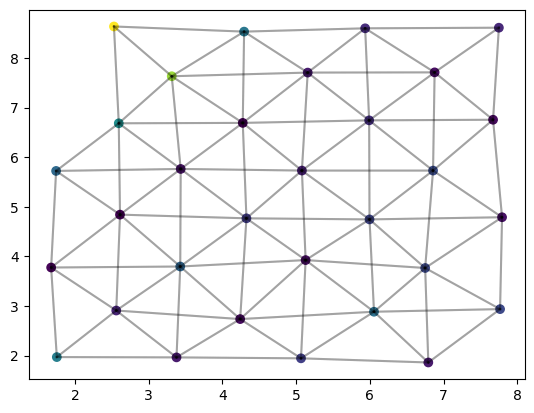

In [76]:
n = 250
dataset = PlaneGraphDataset('plane_graphs', n, size=(5,5))
dataset.process()
plot_graph_tg(dataset[7])
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)

In [82]:
num_features = dataset[0].num_features
num_classes = dataset[0].y.shape[1]
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = tg.nn.GCNConv(num_features, 8)
        self.conv2 = tg.nn.GCNConv(8,6)
        self.classifier = torch.nn.Linear(6, num_classes)
    def forward(self, x, edge_index, batch):
        x = torch.tanh(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = tg.nn.global_mean_pool(x, batch)
        out = self.classifier(x)
        return out
model1 = GCN()
print(model1)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
criterion1 = torch.nn.CrossEntropyLoss()

def train1(loader):
    model1.train()
    for data in loader:
        out = model1(data.x, data.edge_index, data.batch)# Perform a single forward pass.
        loss = criterion1(out, data.y)  # Compute the loss.
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer1.step()  # Update parameters based on gradients.
        optimizer1.zero_grad() # Reset grads.
def test1(loader):
    model1.eval()
    correct = 0
    for data in loader:
        out = model1(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        true = data.y.argmax(dim=1)
        #print(true)
        correct += int((true == pred).sum())
    return correct / len(loader.dataset)

class GINEConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = tg.nn.GINEConv(torch.nn.Linear(num_features, 8), edge_dim=1)
        self.conv2 = tg.nn.GINEConv(torch.nn.Linear(8, 6), edge_dim=1)
        self.classifier = torch.nn.Linear(6, num_classes)
    def forward(self, x, edge_index, edge_attr, batch):
        x = torch.tanh(self.conv1(x, edge_index, edge_attr))
        x = torch.tanh(self.conv2(x, edge_index, edge_attr))
        x = tg.nn.global_mean_pool(x, batch)
        out = self.classifier(x)
        return out
model2 = GINEConv()
print(model2)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005)
criterion2 = torch.nn.CrossEntropyLoss()

def train2(loader):
    model2.train()
    for data in loader:
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)# Perform a single forward pass.
        loss = criterion2(out, data.y)  # Compute the loss.
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer2.step()  # Update parameters based on gradients.
        optimizer2.zero_grad() # Reset grads.
        
def test2(loader):
    model2.eval()
    correct = 0
    for data in loader:
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        true = data.y.argmax(dim=1)
        #print(true)
        correct += int((true == pred).sum())
    return correct / len(loader.dataset)

C:\Users\steph\AppData\Local\Temp\ipykernel_14108\333780533.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:0

GCN(
  (conv1): GCNConv(6, 8)
  (conv2): GCNConv(8, 6)
  (classifier): Linear(in_features=6, out_features=5, bias=True)
)
GINEConv(
  (conv1): GINEConv(nn=Linear(in_features=6, out_features=8, bias=True))
  (conv2): GINEConv(nn=Linear(in_features=8, out_features=6, bias=True))
  (classifier): Linear(in_features=6, out_features=5, bias=True)
)


In [84]:
for index in range(5):
    model1 = GCN()
    optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.005)
    train_accs = []
    test_accs = []
    test_accs.append(test1(test_loader))
    train_accs.append(test1(train_loader))
    print(test_accs[-1])
    for epoch in range(0, 50):
        train1(train_loader)
        train_accs.append(test1(train_loader))
        test_accs.append(test1(test_loader))
        print(test_accs[-1]) if epoch % 10 == 0 else None
    np.savetxt(f'results_bravais_classification/2d/GCN_{index}.txt', np.column_stack((train_accs, test_accs)), header='train_acc test_acc')
    

# for index in range(5):
#     model2 = GINEConv()
#     optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005)
#     train_accs = []
#     test_accs = []
#     test_accs.append(test2(test_loader))
#     train_accs.append(test2(train_loader))
#     print(test_accs[-1])
#     for epoch in range(0, 50):
#         train2(train_loader)
#         train_accs.append(test2(train_loader))
#         test_accs.append(test2(test_loader))
#         print(test_accs[-1]) if epoch % 10 == 0 else None
#     np.savetxt(f'results_bravais_classification/2d/GINE_{index}.txt', np.column_stack((train_accs, test_accs)), header='train_acc test_acc')

C:\Users\steph\AppData\Local\Temp\ipykernel_14108\333780533.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:0

0.2
0.6
0.84
0.9
0.856
0.916
0.308
0.568
0.856
0.864
0.904
0.896
0.2
0.58
0.892
0.912
0.912
0.916
0.2
0.532
0.908
0.916
0.9
0.92
0.2
0.48
0.844
0.908
0.912
0.908


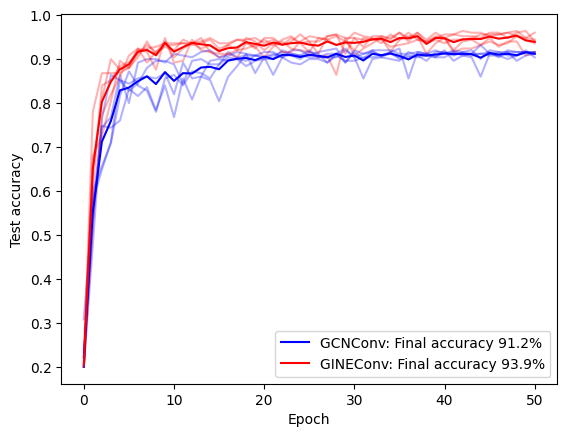

In [92]:
fig,ax = plt.subplots(ncols=1)
gcn = np.zeros(51)
gine = np.zeros(51)
for index in range(5):
    data = np.loadtxt(f'results_bravais_classification/2d/GCN_{index}.txt')
    gcn += data[:,1]
    ax.plot(data[:,1], 'blue', alpha=0.3)
    data = np.loadtxt(f'results_bravais_classification/2d/GINE_{index}.txt')
    gine += data[:,1]
    ax.plot(data[:,1], 'red', alpha=0.3)
ax.plot(gcn/5, 'blue', label='GCNConv: Final accuracy {:.1f}%'.format(gcn[-1]/5*100))   
ax.plot(gine/5, 'red', label='GINEConv: Final accuracy {:.1f}%'.format(gine[-1]/5*100))
ax.set(xlabel='Epoch', ylabel='Test accuracy')
ax.legend()

# 3D

In [2]:
import numpy as np
rng = np.random.default_rng()
import os
import torch_geometric as tg
import torch
from tqdm import trange
from scipy.spatial import KDTree
import boo

class ThreeDGraphDataset(tg.data.Dataset):
    '''
    This class bundles the creation and saving as well as loading of a dataset of 3D graphs. If an instance is created, the class will 
    check in root directory if the dataset is already processed. If not, the process() method will be called. Furthermore, the
    dataset will be loaded. If the dataset shall be calculated again, the process() method must be called explicitely.
    '''
    def __init__(self, root, n_graphs_per_type=100, size=(5,5,5), transform=None, pre_transform=None):
        '''
        Args:
        - root (str): The directory where the dataset should be stored, divided into processed and raw dirs
        '''
        self.root = root
        self.n_graphs_per_type = n_graphs_per_type
        self.size = np.array(size) + 3
        super().__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        '''
        If this file exists in the raw directory, the download will be skipped. Download not implemented.
        '''
        return 'raw.txt'
    
    @property
    def processed_file_names(self):
        '''
        If this file exists in the processed directory, processing will be skipped. 
        Note: This does smh not work, therefore files are ATM recalculated every time.
        '''
        return ['data_00000.pt']
    
    def download(self):
        '''
        Download not implemented.
        '''
        pass
    
    def len(self):
        '''
        Returns the number of graphs in the dataset.
        '''
        return len([f for f in os.listdir(os.path.join(self.root, 'processed')) if f.startswith('data')])
    
    def get(self, idx):
        '''
        Returns the graph at index idx. 
        '''
        data = torch.load(os.path.join(self.processed_dir, 'data_{:05d}.pt'.format(idx)))
        return data
    
    def process(self):
        '''
        Here creation, processing and saving of the dataset happens. 
        '''

        lattice_types = {
             0: {'name': 'aP', 'nodes': self._get_P_nodes, 'binding_angles': [  0,   0,   0], 'scale': [0, 0, 0]},
             1: {'name': 'mP', 'nodes': self._get_P_nodes, 'binding_angles': [ 90,   0,  90], 'scale': [0, 0, 0]},
             2: {'name': 'mS', 'nodes': self._get_S_nodes, 'binding_angles': [ 90,   0,  90], 'scale': [0, 0, 0]},
             3: {'name': 'oP', 'nodes': self._get_P_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [0, 0, 0]},
             4: {'name': 'oS', 'nodes': self._get_S_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [0, 0, 0]},
             5: {'name': 'oI', 'nodes': self._get_I_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [0, 0, 0]},
             6: {'name': 'oF', 'nodes': self._get_F_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [0, 0, 0]},
             7: {'name': 'tP', 'nodes': self._get_P_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [1, 1, 0]},
             8: {'name': 'tI', 'nodes': self._get_I_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [1, 1, 0]},
             9: {'name': 'hR', 'nodes': self._get_P_nodes, 'binding_angles': [  0,   0,   0], 'scale': [1, 1, 1]},
            10: {'name': 'hP', 'nodes': self._get_P_nodes, 'binding_angles': [ 90,  90, 120], 'scale': [1, 1, 0]},
            11: {'name': 'cP', 'nodes': self._get_P_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [1, 1, 1]},
            12: {'name': 'cI', 'nodes': self._get_I_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [1, 1, 1]},
            13: {'name': 'cF', 'nodes': self._get_F_nodes, 'binding_angles': [ 90,  90,  90], 'scale': [1, 1, 1]},
        }

        
        for n in trange(self.n_graphs_per_type * 14):
            # Get graph features:
            pos, edge_index, label, node_attr, edge_attr = self._process_lattice(lattice_types[n % 14], n%14)
            
            # Create data object:
            data = tg.data.Data(x          = torch.tensor(node_attr, dtype=torch.float), 
                                edge_index = torch.tensor(edge_index, dtype=torch.int64), 
                                y          = torch.tensor(label, dtype=torch.float), 
                                pos        = torch.tensor(pos, dtype=torch.float),
                                edge_attr  = torch.tensor(edge_attr, dtype=torch.float)
                                )
            # Save data object:
            torch.save(data, os.path.join(self.processed_dir, 'data_{:05d}.pt'.format(n)))


    def _get_P_nodes(self, angles=np.array([90,90,90])):
        '''
        Get the nodes of a primitive lattice.
        '''
        scaling = np.sin(np.radians(angles))
        vec1 = np.arange(0,self.size[0],1)
        vec2 = np.arange(0,self.size[1]*scaling[2],1*scaling[2])
        vec3 = np.arange(0,self.size[2]*scaling[1],1*scaling[1])
        a, b, c = np.meshgrid(vec1,vec2, vec3)
        nodes = np.stack([a,b,c],axis=-1) # Stack them in a new axis
        nodes = np.reshape(nodes, (-1, 3)) # Reshape to an arr of nodes with shape (#nodes, 3)
        return nodes

    def _get_S_nodes(self):
        '''
        Get the nodes of a base-centred lattice.
        '''
        P = self._get_P_nodes()
        extra = P + np.array([0.5,0.5,0])
        return np.append(P,extra,axis=0)

    def _get_I_nodes(self):
        '''
        Get the nodes of a body-centred lattice.
        '''
        P = self._get_P_nodes()
        extra = P + 0.5
        return np.append(P,extra,axis=0)

    def _get_F_nodes(self):
        '''
        Get the nodes of a face-centred lattice.
        '''
        P = self._get_P_nodes()
        extra1 = P + np.array([0.5,0.5,0])
        extra2 = P + np.array([0,0.5,0.5])
        extra3 = P + np.array([0.5,0,0.5])
        return np.row_stack((P, extra1, extra2, extra3))
    

    def _process_lattice(self, arg_dict, n):
        '''
        Method that processes a lattice of a given type. The method is called with a dictionary holding parameters for one of the lattice types. It contains the following keys:
            - name: The name of the lattice type
            - nodes: The method to get the fitting fundamental lattice nodes
            - binding_angles: A list of binding angles [alpha, beta, gamma] of the lattice type. Angles are in degrees. 0° means to generate a independent random angle (0,180)°
            - scale: A list of scaling factors [x,y,z] for the lattice type. 0 means to generate a random scaling factor (0,2)
        '''
        # Get lattice angles
        angles = np.array(arg_dict['binding_angles'])
        if arg_dict['name'] == 'hR':
            # Special case for hR lattice as it has 3 identical but random angles
            angles = np.where(angles == 0, rng.uniform(46,89,1), angles)
        else:
            angles = np.where(angles == 0, rng.uniform(46,89,3), angles)
            
        # Get the fundamental lattice nodes
        if arg_dict['name'] in ['hR', 'hP']:
            # For hR and hP lattices we need to give the angles to the nodes method so that sheared connections are equally long
            nodes = arg_dict['nodes'](angles)
        else:
            nodes = arg_dict['nodes']()

        inside_mask = self._get_inside_mask(nodes)
        nodes = self._shear_nodes(nodes, angles)
        # Find random scale and apply gaussian noise to the lattice accordingly
        scale = np.array(arg_dict['scale'])
        scale = np.where(scale == 0, rng.uniform(0.1,3,3), scale)
        noise_level = 0.05 / scale  # At this step we scale the noise down, so that the scaling later on does not affect the noise level
        nodes += rng.normal(0, noise_level, nodes.shape)

        # Find the connections between the nodes in a given radius
        cons= self._get_cons_in_radius(nodes, 1.3+np.mean(noise_level))
        # Apply the saved scaling
        nodes *= scale
        
        nodes, cons, inside_mask = self._add_defects(nodes, cons, inside_mask)
        node_attr = self._get_node_attr(nodes, cons)
        nodes, node_attr = nodes[inside_mask], node_attr[inside_mask]
        nodes /= scale
        cons = self._get_cons_in_radius(nodes, 1.3+np.mean(noise_level))
        nodes *= scale
        edge_attr = self._get_edge_attr(nodes, cons)
        labels = np.zeros((1,14))
        labels[0,n] = 1
        return nodes, cons, labels, node_attr, edge_attr

    
    def _get_cons_in_radius(self, nodes, radius):
        '''
        Get the connections in a radius as well as the total number of cons for each node.
        '''
        tree = KDTree(nodes)
        cons = tree.query_pairs(radius, output_type='ndarray', p=2)
        cons = cons.T
        cons = np.column_stack((cons, cons[::-1])) # Add the reverse connections
        return cons

    def _shear_nodes(self, nodes, binding_angle):
        '''
        Shear nodes. Binding angle is a 3D vector with the Binding angle in each axis.
        '''
        delta = np.tan(np.radians(np.array(binding_angle)))
        assert not np.any(delta == 0), 'Binding angle cannot be 0'
        nodes = nodes.astype(float)
        nodes = nodes + np.stack((nodes[:,2]/delta[0] + nodes[:,1]/delta[2], nodes[:,2]/delta[1] , np.zeros_like(nodes[:,1])), axis=1)
        return nodes

    def _add_defects(self, nodes, edge_index, inside_mask):
        '''
        Method that adds up to 10% of random defects (i.e. missing nodes) to the lattice. Should be called after _get_*_graph() but before
        _get_edge_attr() and _get_node_attr().
        '''
        # Draw up to 10% of unique random indices for nodes to be removed
        drop_indices = rng.choice(np.arange(len(nodes)), rng.integers(len(nodes)//10), replace=False)
        # Remove the nodes and labels
        nodes = np.delete(nodes, drop_indices, axis=0)
        inside_mask = np.delete(inside_mask, drop_indices, axis=0)
        # Delete every connection that refers to a removed node
        edge_index = np.delete(edge_index, np.where(np.isin(edge_index, drop_indices))[1], axis=1)
        
        # As edge_index refers to the original node indices, we need to adjust the indices of most connections
        # For this we create a mapping from old indices to new indices
        old_to_new = np.arange(len(nodes) + len(drop_indices))  # Start with an array of original indices; [0,1,2,3,4,5,...]
        old_to_new[drop_indices] = -1  # Mark the indices of the nodes to be deleted; eg. drop_indices = [1,3] -> [0,-1,2,-1,4,5,...]
        old_to_new = np.cumsum(old_to_new != -1) - 1  # Create a cumulative sum array; cumsum([True, False, True, False, True, True,...]) -1 -> [1,1,2,2,3,4,...] -1 -> [0,0,1,1,2,3,...]
        
        # # Update edge indices to reflect new node indices through broadcasting magic
        edge_index = old_to_new[edge_index]
        return nodes, edge_index, inside_mask
        
    def _get_node_attr(self,nodes,cons):
        '''
        Method that returns the node attributes for each node in the graph. Should be called after creating the graph and adding defects.
        The node attributes have the shape (num_nodes, num_node_features). For each node, the node features are the following:
        - The bond orientational order parameters for l=4,6,8,10 (4 features)
        '''
        boo_cons = cons.T[:cons.shape[1]//2] # Get cons in shape (#cons,2) and remove bidirectional connections
        boo_l2  = boo.ql(boo.bonds2qlm(nodes, boo_cons, l=2)).reshape(nodes.shape[0],1)
        boo_l4  = boo.ql(boo.bonds2qlm(nodes, boo_cons, l=4)).reshape(nodes.shape[0],1)
        boo_l6  = boo.ql(boo.bonds2qlm(nodes, boo_cons, l=6)).reshape(nodes.shape[0],1)
        boo_l8  = boo.ql(boo.bonds2qlm(nodes, boo_cons, l=8)).reshape(nodes.shape[0],1)
        boo_l10 = boo.ql(boo.bonds2qlm(nodes, boo_cons, l=10)).reshape(nodes.shape[0],1)
        
        n_neighbors = np.zeros(len(nodes))
        for i in range(len(nodes)):
            n_neighbors[i] = np.sum(cons[0] == i)
        n_neighbors = n_neighbors.reshape(-1,1)
        return np.concatenate((boo_l2, boo_l4,boo_l6,boo_l8,boo_l10, n_neighbors),axis=1)
    
    def _get_edge_attr(self,nodes,cons):
        '''
        Method that returns the edge attributes for each edge in the graph. Should be called after creating the graph and adding defects.
        Returns an array of shape (len(edge_index[0])= #Edges, 2) with the entries [dx,dy] for each edge.
        '''
        # Get the edge vectors for each edge
        edge_vectors = nodes[cons[0]] - nodes[cons[1]]
        return np.linalg.norm(edge_vectors, axis=1).reshape(-1,1)
    
    def _get_inside_mask(self, nodes):
        '''
        Method that returns the indices of the border nodes of the lattice. 
        '''
        mask = np.any(np.logical_or(nodes < np.array([1,1,1]), nodes >= self.size-3), axis=1)
        return ~mask
    

100%|██████████| 3500/3500 [08:25<00:00,  6.92it/s]
C:\Users\steph\AppData\Local\Temp\ipykernel_4152\2050623007.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

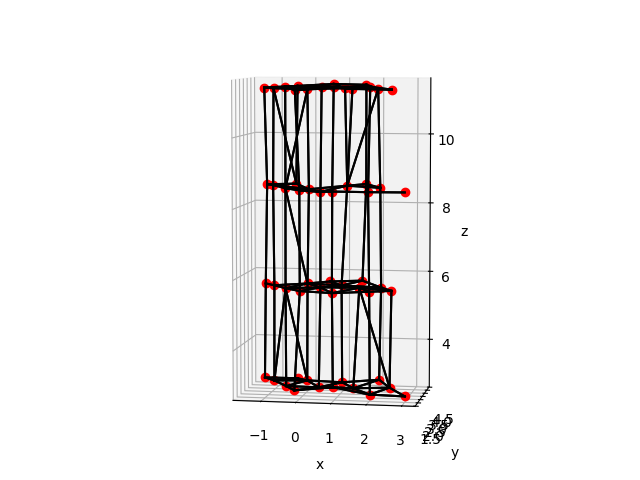

In [14]:
n = 250
dataset = ThreeDGraphDataset('3d_graphs', n_graphs_per_type=n, size=(5,5,5))
# dataset.process()
train_loader = tg.loader.DataLoader(dataset[:n*12], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*12:], batch_size=16, shuffle=True)
def plot_3D(nodes,cons=None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot(nodes[:,0], nodes[:,1], nodes[:,2], 'o', color='red')
    #ax.plot(m_rot[:,0], m_rot[:,1], m_rot[:,2], '+', color=cmap[1])
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    if cons is not None:
        for con in cons.T:
            # This for loop is necessary, 3d plotting is weird.
            ax.plot([nodes[con[0],0], nodes[con[1],0]], [nodes[con[0],1], nodes[con[1],1]], [nodes[con[0],2], nodes[con[1],2]], '-', color='black')
      
    ax.view_init(6, -80, 0)
    ax.set_aspect('equal')
    plt.show()
    
plot_3D(dataset[10].pos,dataset[10].edge_index)

In [15]:
num_features = dataset[0].num_features
num_classes = dataset[0].y.shape[1]
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = tg.nn.GCNConv(num_features, 8)
        self.conv2 = tg.nn.GCNConv(8,12)
        self.classifier = torch.nn.Linear(12, num_classes)
    def forward(self, x, edge_index, batch):
        x = torch.tanh(self.conv1(x, edge_index))
        x = torch.tanh(self.conv2(x, edge_index))
        x = tg.nn.global_mean_pool(x, batch)
        out = self.classifier(x)
        return out
model1 = GCN()
print(model1)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.005)
criterion1 = torch.nn.CrossEntropyLoss()

def train1(loader):
    model1.train()
    for data in loader:
        out = model1(data.x, data.edge_index, data.batch)# Perform a single forward pass.
        loss = criterion1(out, data.y)  # Compute the loss.
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer1.step()  # Update parameters based on gradients.
        optimizer1.zero_grad() # Reset grads.
def test1(loader):
    model1.eval()
    correct = 0
    for data in loader:
        out = model1(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        true = data.y.argmax(dim=1)
        #print(true)
        correct += int((true == pred).sum())
    return correct / len(loader.dataset)

class GINEConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = tg.nn.GINEConv(torch.nn.Linear(num_features, 8), edge_dim=1)
        self.conv2 = tg.nn.GINEConv(torch.nn.Linear(8, 12), edge_dim=1)
        self.classifier = torch.nn.Linear(12, num_classes)
    def forward(self, x, edge_index, edge_attr, batch):
        x = torch.tanh(self.conv1(x, edge_index, edge_attr))
        x = torch.tanh(self.conv2(x, edge_index, edge_attr))
        x = tg.nn.global_mean_pool(x, batch)
        out = self.classifier(x)
        return out
model2 = GINEConv()
print(model2)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005)
criterion2 = torch.nn.CrossEntropyLoss()

def train2(loader):
    model2.train()
    for data in loader:
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)# Perform a single forward pass.
        loss = criterion2(out, data.y)  # Compute the loss.
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer2.step()  # Update parameters based on gradients.
        optimizer2.zero_grad() # Reset grads.
        
def test2(loader):
    model2.eval()
    correct = 0
    for data in loader:
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        true = data.y.argmax(dim=1)
        #print(true)
        correct += int((true == pred).sum())
    return correct / len(loader.dataset)

GCN(
  (conv1): GCNConv(6, 8)
  (conv2): GCNConv(8, 12)
  (classifier): Linear(in_features=12, out_features=14, bias=True)
)
GINEConv(
  (conv1): GINEConv(nn=Linear(in_features=6, out_features=8, bias=True))
  (conv2): GINEConv(nn=Linear(in_features=8, out_features=12, bias=True))
  (classifier): Linear(in_features=12, out_features=14, bias=True)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_4152\2050623007.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:0

In [ ]:
for index in range(5):
    model1 = GCN()
    optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.005)
    train_accs = []
    test_accs = []
    test_accs.append(test1(test_loader))
    train_accs.append(test1(train_loader))
    print(test_accs[-1])
    for epoch in range(0, 50):
        train1(train_loader)
        train_accs.append(test1(train_loader))
        test_accs.append(test1(test_loader))
        print(test_accs[-1]) if epoch % 10 == 0 else None
    np.savetxt(f'results_bravais_classification/3d/GCN_{index}.txt', np.column_stack((train_accs, test_accs)), header='train_acc test_acc')
    

# for index in range(5):
#     model2 = GINEConv()
#     optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005)
#     train_accs = []
#     test_accs = []
#     test_accs.append(test2(test_loader))
#     train_accs.append(test2(train_loader))
#     print(test_accs[-1])
#     for epoch in range(0, 50):
#         train2(train_loader)
#         train_accs.append(test2(train_loader))
#         test_accs.append(test2(test_loader))
#         print(test_accs[-1]) if epoch % 10 == 0 else None
#     np.savetxt(f'results_bravais_classification/3d/GINE_{index}.txt', np.column_stack((train_accs, test_accs)), header='train_acc test_acc')

C:\Users\steph\AppData\Local\Temp\ipykernel_4152\2050623007.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:0

0.072
0.282
0.598
0.648
0.63
